In [2]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import pytorch_lightning as pl

In [4]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)
                ),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

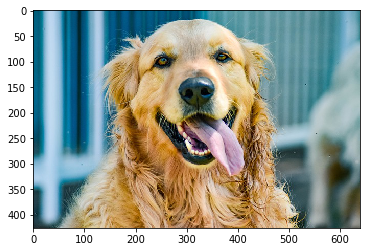

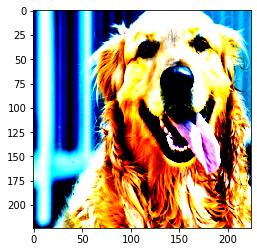

In [16]:
image_file_path = '../original/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [28]:
class HymenopteraDataset(data.Dataset):
    
    def __init__(self, transform=None, phase='train'):
        self.file_list = self._make_datapath_list(phase=phase)
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(
            img, self.phase)
        
        label = img_path.split('/')[-2]
            
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
        
        return img_transformed, label

    def _make_datapath_list(self, phase='train'):
        rootpath = '../original/1_image_classification/data/hymenoptera_data/'
        target_path = osp.join(rootpath, phase, '**/*.jpg')
        
        return list(glob.glob(target_path))

In [29]:
train_dataset = HymenopteraDataset(transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [38]:
class HymenopteraModel(pl.LightningModule):

    def __init__(self, train_ds, val_ds, batch_size):
        super(HymenopteraModel, self).__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.batch_size = batch_size
        self.net = models.vgg16(pretrained=True)
        self.net.classifier[6] = nn.Linear(4096, 2)
        self.criterion = nn.CrossEntropyLoss()

        for name, param in self.net.named_parameters():
            if name in ['classifier.6.weight', 'classifier.6.bias']:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'loss': self.criterion(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        _, preds = torch.max(y_hat, 1)
        return {
            'val_loss': self.criterion(y_hat, y),
            'val_acc': torch.sum(preds == y.data).double() / y.shape[0]
        }

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        return {
            'avg_val_loss': avg_loss,
            'avg_val_acc': avg_acc,
        }

    def configure_optimizers(self):
        return optim.SGD(
            params=[param for param in self.parameters() if param.requires_grad],
            lr=0.001,
            momentum=0.9
        )

    @pl.data_loader
    def tng_dataloader(self):
        return data.DataLoader(self.train_ds, shuffle=True, batch_size=self.batch_size)

    @pl.data_loader
    def val_dataloader(self):
        return data.DataLoader(self.val_ds, shuffle=False, batch_size=self.batch_size)

In [46]:
model = HymenopteraModel(train_dataset, val_dataset, 32)
trainer = pl.Trainer(max_nb_epochs=10, gpus=[0, 1])
trainer.fit(model)

  0%|          | 0/5 [00:00<?, ?it/s]

VISIBLE GPUS: '0,1'
gpu available: True, used: True
                Name               Type     Params
0                net                VGG  134268738
1       net.features         Sequential   14714688
2     net.features.0             Conv2d       1792
3     net.features.1               ReLU          0
4     net.features.2             Conv2d      36928
5     net.features.3               ReLU          0
6     net.features.4          MaxPool2d          0
7     net.features.5             Conv2d      73856
8     net.features.6               ReLU          0
9     net.features.7             Conv2d     147584
10    net.features.8               ReLU          0
11    net.features.9          MaxPool2d          0
12   net.features.10             Conv2d     295168
13   net.features.11               ReLU          0
14   net.features.12             Conv2d     590080
15   net.features.13               ReLU          0
16   net.features.14             Conv2d     590080
17   net.features.15          

100%|██████████| 13/13 [00:04<00:00,  4.86it/s, avg_val_acc=0.954, avg_val_loss=0.0831, batch_nb=7, epoch=9, gpu=0, loss=0.135]

1